# MLP
MLP, K=5, lncRNA.

Droput.

In [60]:
from datetime import datetime
print(datetime.now())

2023-04-06 16:38:44.791364


In [61]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [62]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=120 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

Python 3.9.16
sklearn 1.2.2


In [63]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [64]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [65]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [66]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [67]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-06 16:38:46.263593
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 64)                65664     
                                                                 
 dense_137 (Dense)           (None, 64)                4160      
                                                                 
 dropout_68 (Dropout)        (None, 64)                0         
                                                                 
 dense_138 (Dense)           (None, 64)                4160      
                                                                 
 dropout_69 (Dropout)        (None, 64)                0         
                                                                 
 dense_139 (Dense)           (None, 1)                 65        
                                                                 
Total params: 74,049
Train

## Training

In [68]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [69]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-06 16:38:46.480515
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.

Training # 1 1
2023-04-06 16:38:55.977325
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-06 16:38:55.989892
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Valid 1:0 458:412 52.64%
FIT
2023-04-06 16:38:56.086474


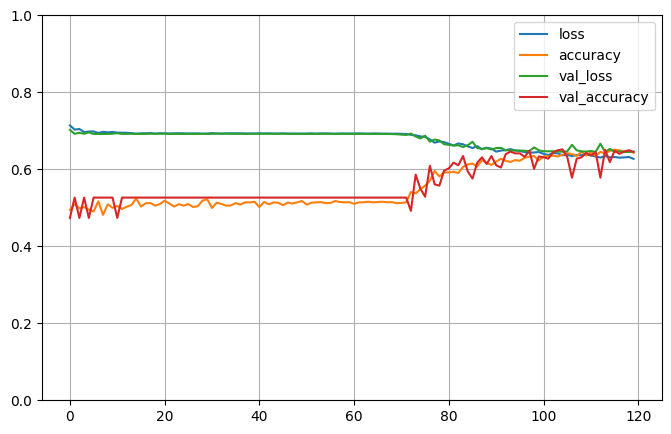


Testing # 1 1
2023-04-06 16:39:56.852163
2023-04-06 16:39:56.852212
PREDICT
2023-04-06 16:39:56.867973
Test 1:0 458:412 52.64%
Predict 1:0 439:431 50.46%
Test sizes (870, 1025) (870,)
Distrib of scores: 0.50282973 mean 0.15932451 std
Range of scores: 0.070677735 to 0.88848454
Score threshold 0.5
Confusion matrix
 [[267 145]
 [164 294]]
Normalized matrix
 [[0.30689655 0.16666667]
 [0.18850575 0.33793103]]


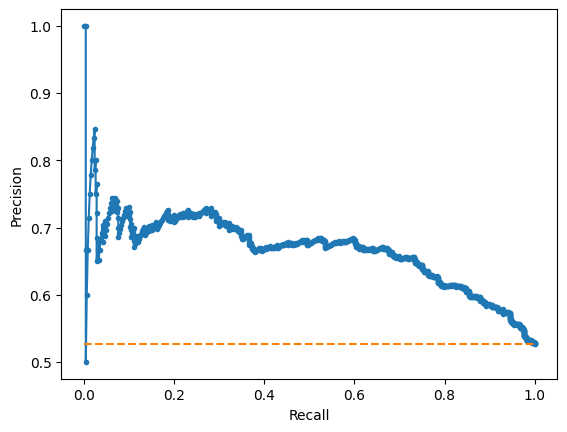

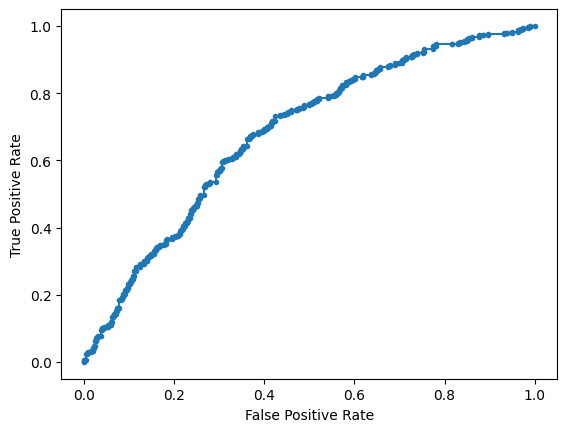

Accuracy: 64.48% Precision: 66.97% Recall: 64.19%
F1: 65.55% MCC: 0.2896
AUPRC: 66.60% AUROC: 67.98%
 accuracy [64.48275862068965]
 precision [66.97038724373576]
 recall [64.19213973799127]
 F1 [65.55183946488295]
 MCC [0.2895862738848079]
 AUPRC [66.60339423085344]
 AUROC [67.9834230720312]

Training # 1 2
2023-04-06 16:39:57.479698
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-06 16:39:57.504459
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Valid 1:0 442:442 50.00%
FIT
2023-04-06 16:39:57.606430


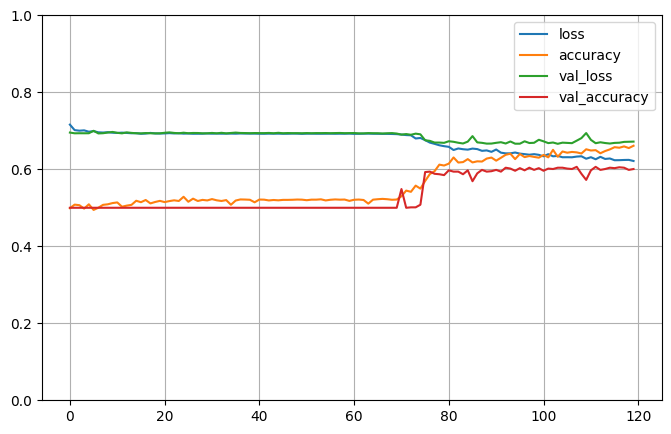


Testing # 1 2
2023-04-06 16:41:01.504420
2023-04-06 16:41:01.504895
PREDICT
2023-04-06 16:41:01.513781
Test 1:0 442:442 50.00%
Predict 1:0 571:313 64.59%
Test sizes (884, 1025) (884,)
Distrib of scores: 0.55044854 mean 0.16841784 std
Range of scores: 0.06674534 to 0.8711139
Score threshold 0.5
Confusion matrix
 [[201 241]
 [112 330]]
Normalized matrix
 [[0.22737557 0.27262443]
 [0.12669683 0.37330317]]


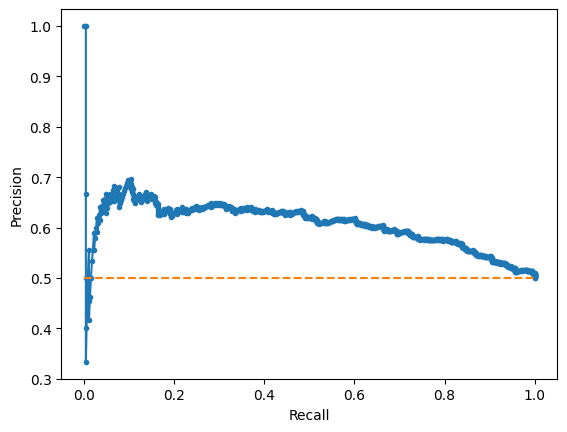

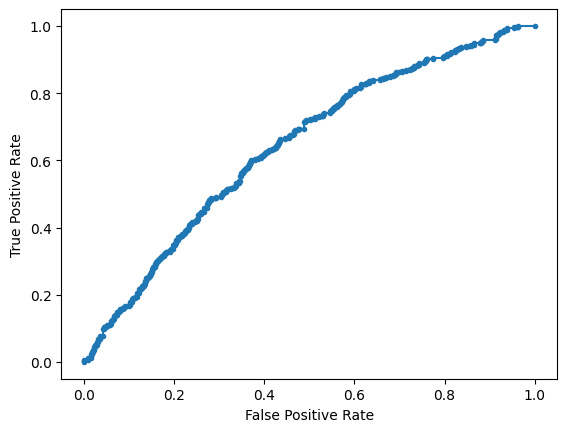

Accuracy: 60.07% Precision: 57.79% Recall: 74.66%
F1: 65.15% MCC: 0.2105
AUPRC: 60.68% AUROC: 64.18%
 accuracy [60.06787330316742]
 precision [57.79334500875657]
 recall [74.6606334841629]
 F1 [65.15301085883515]
 MCC [0.21052311322027678]
 AUPRC [60.68474387127986]
 AUROC [64.18173256075839]

Training # 1 3
2023-04-06 16:41:02.130527
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-06 16:41:02.151498
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Valid 1:0 442:407 52.06%
FIT
2023-04-06 16:41:02.245834


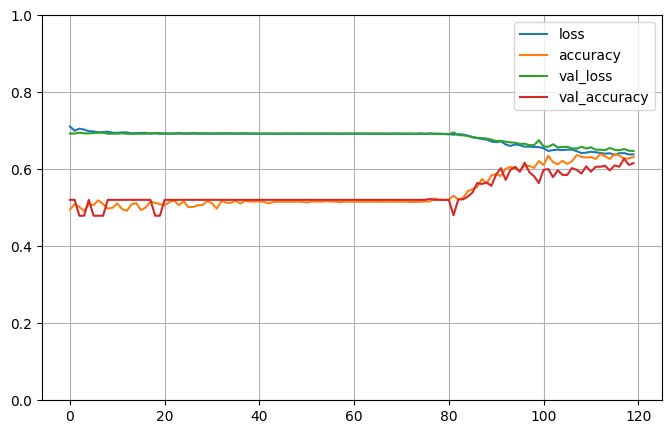


Testing # 1 3
2023-04-06 16:42:25.474383
2023-04-06 16:42:25.474440
PREDICT
2023-04-06 16:42:25.489673
Test 1:0 442:407 52.06%
Predict 1:0 466:383 54.89%
Test sizes (849, 1025) (849,)
Distrib of scores: 0.5222976 mean 0.1424354 std
Range of scores: 0.09370554 to 0.85995984
Score threshold 0.5
Confusion matrix
 [[232 175]
 [151 291]]
Normalized matrix
 [[0.27326266 0.20612485]
 [0.1778563  0.34275618]]


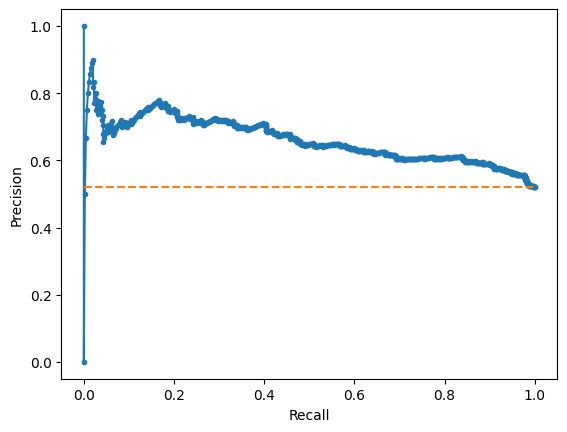

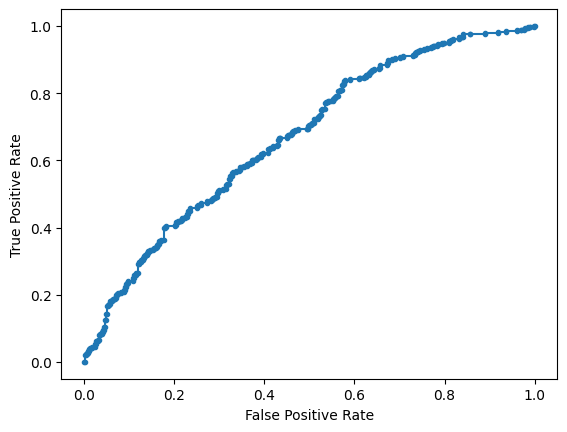

Accuracy: 61.60% Precision: 62.45% Recall: 65.84%
F1: 64.10% MCC: 0.2293
AUPRC: 65.96% AUROC: 66.91%
 accuracy [61.601884570082454]
 precision [62.44635193133047]
 recall [65.83710407239819]
 F1 [64.09691629955947]
 MCC [0.22929983775935012]
 AUPRC [65.95949022209251]
 AUROC [66.91384926679045]

Training # 1 4
2023-04-06 16:42:26.085769
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-06 16:42:26.109299
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Valid 1:0 459:431 51.57%
FIT
2023-04-06 16:42:26.208429


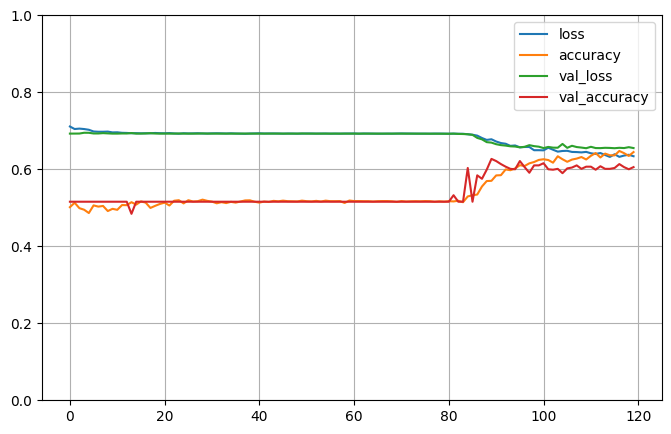


Testing # 1 4
2023-04-06 16:43:49.513973
2023-04-06 16:43:49.514413
PREDICT
2023-04-06 16:43:49.524822
Test 1:0 459:431 51.57%
Predict 1:0 488:402 54.83%
Test sizes (890, 1025) (890,)
Distrib of scores: 0.5200622 mean 0.15087846 std
Range of scores: 0.10826439 to 0.9176351
Score threshold 0.5
Confusion matrix
 [[241 190]
 [161 298]]
Normalized matrix
 [[0.27078652 0.21348315]
 [0.18089888 0.33483146]]


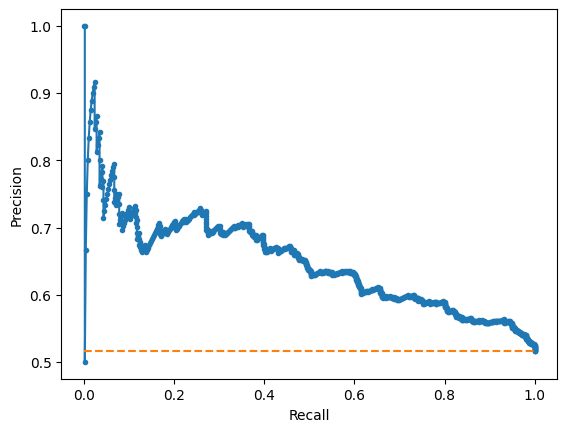

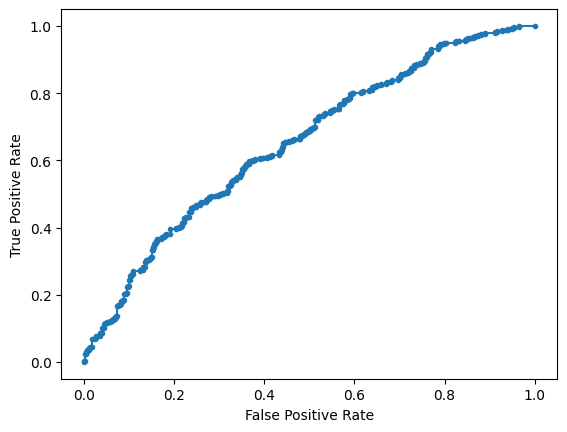

Accuracy: 60.56% Precision: 61.07% Recall: 64.92%
F1: 62.94% MCC: 0.2093
AUPRC: 64.78% AUROC: 65.19%
 accuracy [60.561797752808985]
 precision [61.065573770491795]
 recall [64.92374727668845]
 F1 [62.93558606124603]
 MCC [0.20927837380690964]
 AUPRC [64.78317251703159]
 AUROC [65.19266639370366]

Training # 1 5
2023-04-06 16:43:50.110683
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-06 16:43:50.133160
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Valid 1:0 457:419 52.17%
FIT
2023-04-06 16:43:50.228894


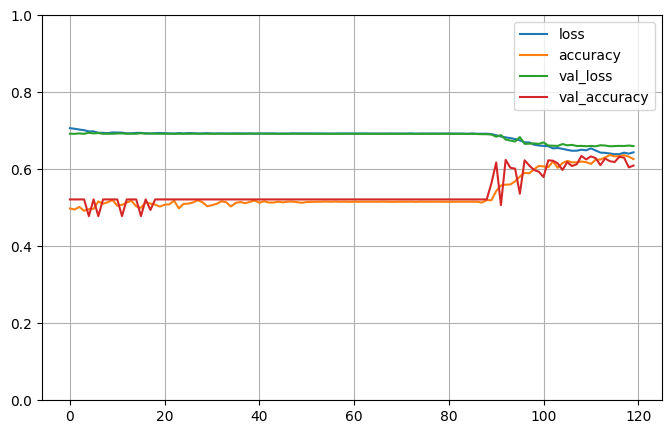


Testing # 1 5
2023-04-06 16:44:52.159675
2023-04-06 16:44:52.159727
PREDICT
2023-04-06 16:44:52.173616
Test 1:0 457:419 52.17%
Predict 1:0 533:343 60.84%
Test sizes (876, 1025) (876,)
Distrib of scores: 0.54275376 mean 0.1378654 std
Range of scores: 0.1914473 to 0.9027006
Score threshold 0.5
Confusion matrix
 [[210 209]
 [133 324]]
Normalized matrix
 [[0.23972603 0.23858447]
 [0.15182648 0.36986301]]


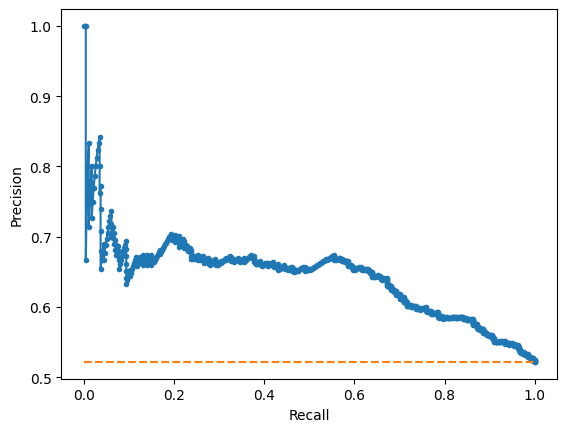

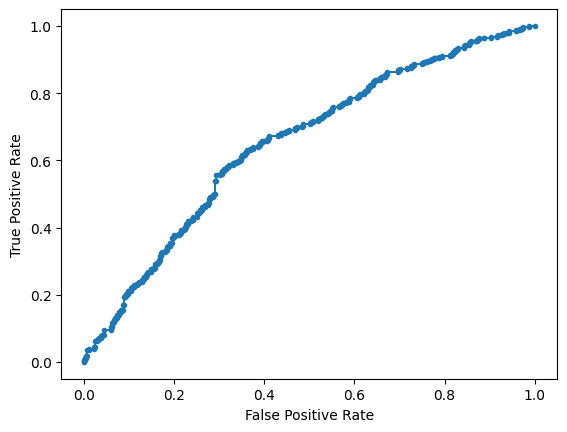

Accuracy: 60.96% Precision: 60.79% Recall: 70.90%
F1: 65.45% MCC: 0.2151
AUPRC: 64.25% AUROC: 65.12%
 accuracy [60.95890410958904]
 precision [60.787992495309574]
 recall [70.89715536105032]
 F1 [65.45454545454545]
 MCC [0.21508720328859043]
 AUPRC [64.24884455301674]
 AUROC [65.11961897400815]

Training # 2 1
2023-04-06 16:44:53.495154
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-06 16:44:53.521512
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Valid 1:0 472:415 53.21%
FIT
2023-04-06 16:44:53.619289


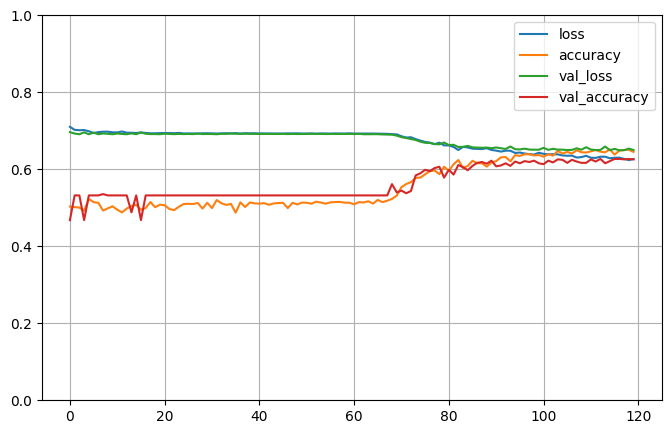


Testing # 2 1
2023-04-06 16:45:55.983148
2023-04-06 16:45:55.983588
PREDICT
2023-04-06 16:45:55.993845
Test 1:0 472:415 53.21%
Predict 1:0 520:367 58.62%
Test sizes (887, 1025) (887,)
Distrib of scores: 0.52468365 mean 0.15833288 std
Range of scores: 0.03683224 to 0.8425368
Score threshold 0.5
Confusion matrix
 [[225 190]
 [142 330]]
Normalized matrix
 [[0.25366404 0.21420519]
 [0.16009019 0.37204059]]


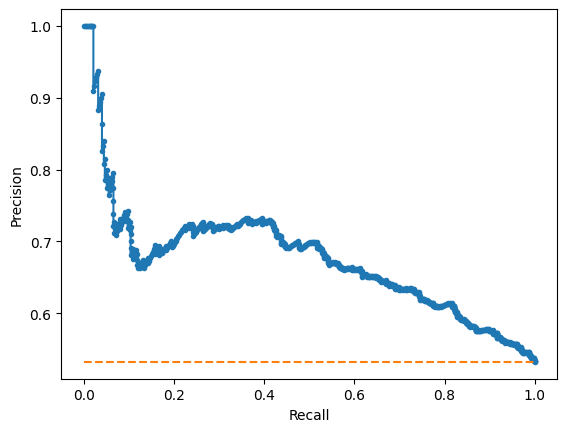

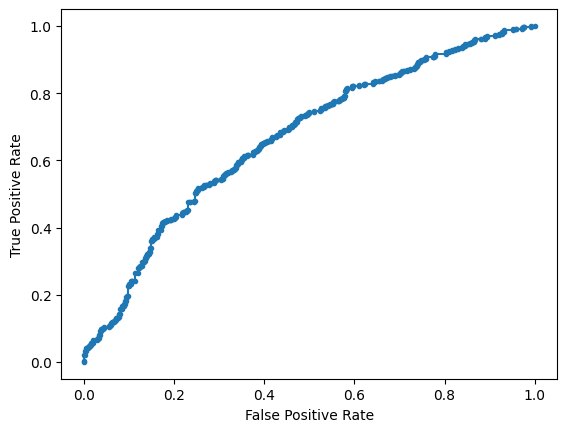

Accuracy: 62.57% Precision: 63.46% Recall: 69.92%
F1: 66.53% MCC: 0.2445
AUPRC: 67.58% AUROC: 66.65%
 accuracy [62.570462232243514]
 precision [63.46153846153846]
 recall [69.91525423728814]
 F1 [66.53225806451613]
 MCC [0.24448704456486353]
 AUPRC [67.58097683790251]
 AUROC [66.6479477230958]

Training # 2 2
2023-04-06 16:45:56.620377
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-06 16:45:56.645966
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Valid 1:0 452:416 52.07%
FIT
2023-04-06 16:45:56.741348


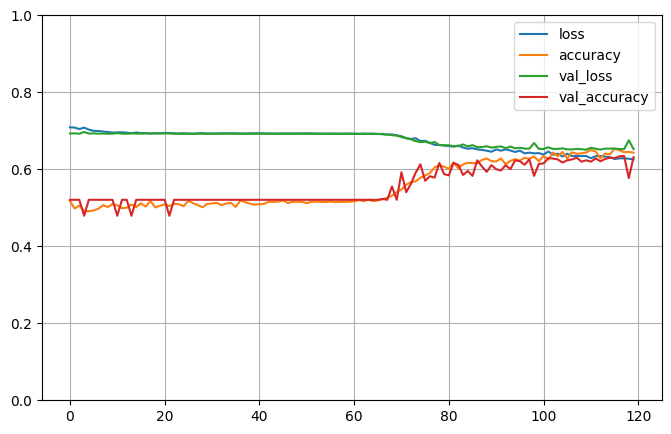


Testing # 2 2
2023-04-06 16:47:00.812894
2023-04-06 16:47:00.812938
PREDICT
2023-04-06 16:47:00.821527
Test 1:0 452:416 52.07%
Predict 1:0 428:440 49.31%
Test sizes (868, 1025) (868,)
Distrib of scores: 0.4967061 mean 0.16422068 std
Range of scores: 0.06811708 to 0.8982464
Score threshold 0.5
Confusion matrix
 [[268 148]
 [172 280]]
Normalized matrix
 [[0.30875576 0.17050691]
 [0.19815668 0.32258065]]


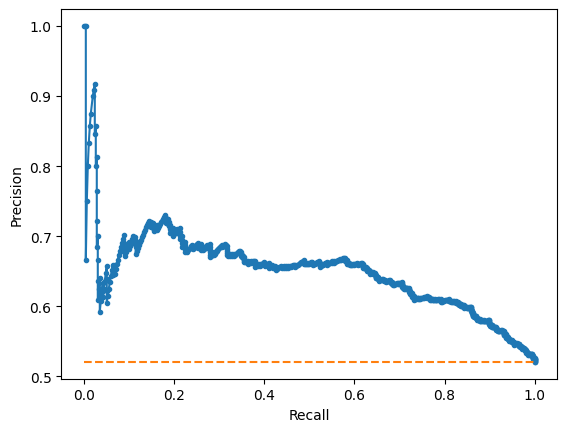

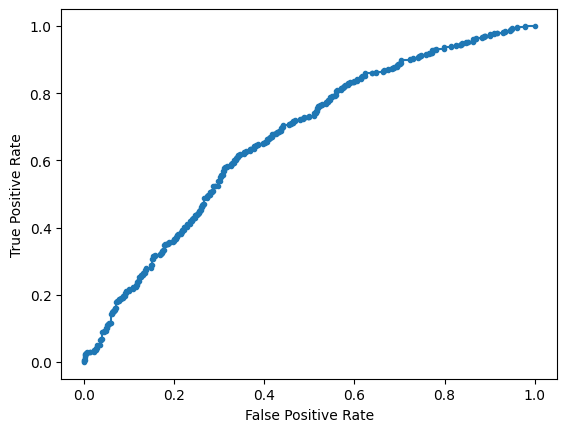

Accuracy: 63.13% Precision: 65.42% Recall: 61.95%
F1: 63.64% MCC: 0.2635
AUPRC: 65.05% AUROC: 66.60%
 accuracy [63.133640552995395]
 precision [65.42056074766354]
 recall [61.94690265486725]
 F1 [63.63636363636363]
 MCC [0.26349807902202993]
 AUPRC [65.05464561106974]
 AUROC [66.59504765146357]

Training # 2 3
2023-04-06 16:47:01.462865
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-06 16:47:01.489827
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Valid 1:0 453:407 52.67%
FIT
2023-04-06 16:47:01.597784


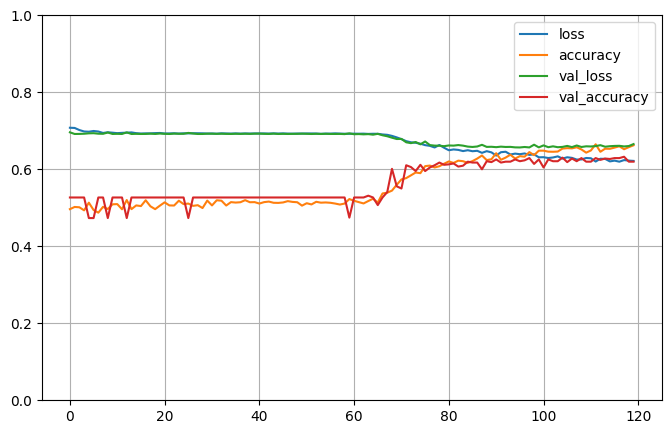


Testing # 2 3
2023-04-06 16:48:03.238821
2023-04-06 16:48:03.238877
PREDICT
2023-04-06 16:48:03.250680
Test 1:0 453:407 52.67%
Predict 1:0 426:434 49.53%
Test sizes (860, 1025) (860,)
Distrib of scores: 0.48649573 mean 0.17495254 std
Range of scores: 0.03140939 to 0.86567765
Score threshold 0.5
Confusion matrix
 [[257 150]
 [177 276]]
Normalized matrix
 [[0.29883721 0.1744186 ]
 [0.20581395 0.32093023]]


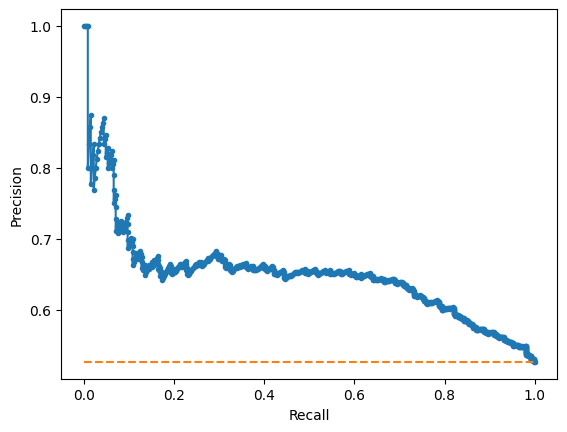

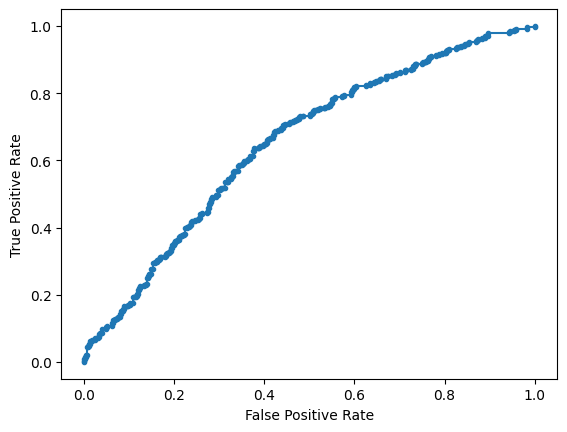

Accuracy: 61.98% Precision: 64.79% Recall: 60.93%
F1: 62.80% MCC: 0.2404
AUPRC: 64.98% AUROC: 65.11%
 accuracy [61.9767441860465]
 precision [64.7887323943662]
 recall [60.9271523178808]
 F1 [62.79863481228669]
 MCC [0.24038695660788964]
 AUPRC [64.98417956851169]
 AUROC [65.11381941845518]

Training # 2 4
2023-04-06 16:48:03.868698
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-06 16:48:03.897591
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Valid 1:0 432:447 49.15%
FIT
2023-04-06 16:48:04.043062


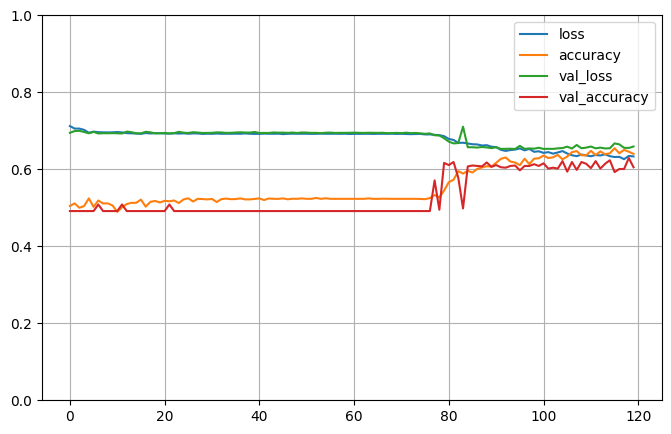


Testing # 2 4
2023-04-06 16:49:08.228039
2023-04-06 16:49:08.228107
PREDICT
2023-04-06 16:49:08.243893
Test 1:0 432:447 49.15%
Predict 1:0 523:356 59.50%
Test sizes (879, 1025) (879,)
Distrib of scores: 0.5335378 mean 0.15498225 std
Range of scores: 0.12666918 to 0.9144729
Score threshold 0.5
Confusion matrix
 [[228 219]
 [128 304]]
Normalized matrix
 [[0.25938567 0.24914676]
 [0.14562002 0.34584755]]


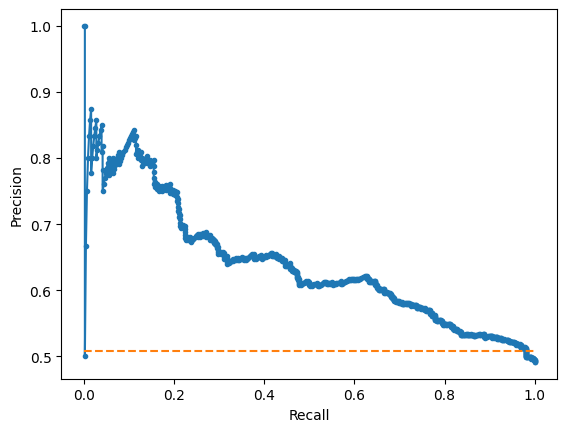

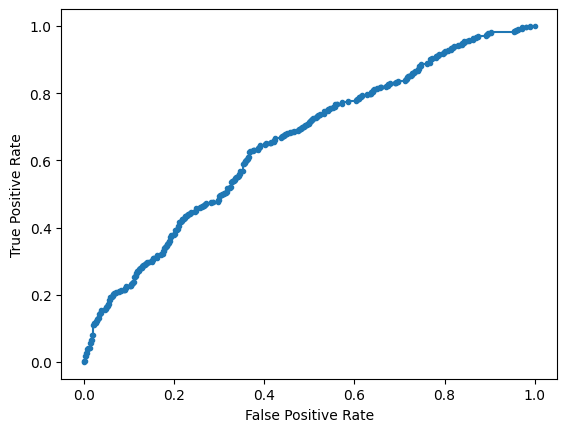

Accuracy: 60.52% Precision: 58.13% Recall: 70.37%
F1: 63.66% MCC: 0.2177
AUPRC: 63.99% AUROC: 65.35%
 accuracy [60.52332195676906]
 precision [58.12619502868069]
 recall [70.37037037037037]
 F1 [63.66492146596858]
 MCC [0.21770490309673907]
 AUPRC [63.994071172392395]
 AUROC [65.35079542629877]

Training # 2 5
2023-04-06 16:49:08.864761
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-06 16:49:08.899010
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Valid 1:0 449:426 51.31%
FIT
2023-04-06 16:49:09.015248


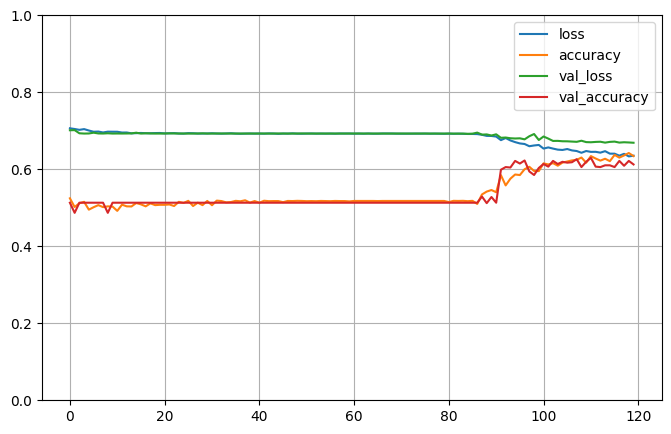


Testing # 2 5
2023-04-06 16:50:32.281328
2023-04-06 16:50:32.281376
PREDICT
2023-04-06 16:50:32.294781
Test 1:0 449:426 51.31%
Predict 1:0 482:393 55.09%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5325689 mean 0.14954412 std
Range of scores: 0.1620925 to 0.9231949
Score threshold 0.5
Confusion matrix
 [[240 186]
 [153 296]]
Normalized matrix
 [[0.27428571 0.21257143]
 [0.17485714 0.33828571]]


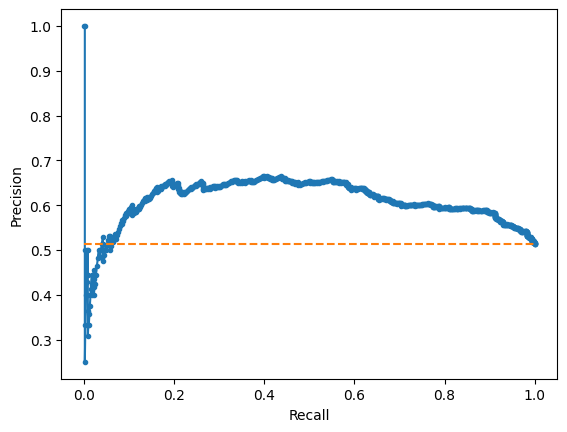

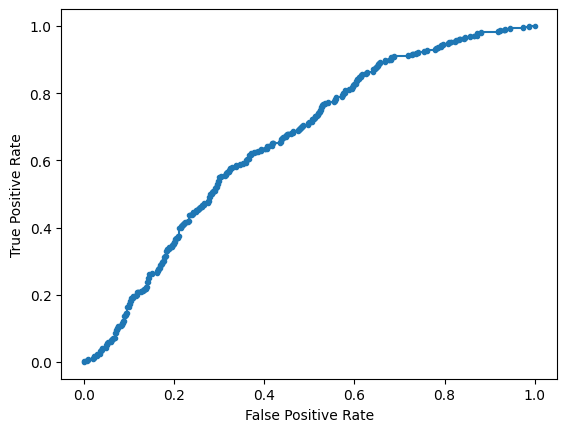

Accuracy: 61.26% Precision: 61.41% Recall: 65.92%
F1: 63.59% MCC: 0.2237
AUPRC: 60.88% AUROC: 65.63%
 accuracy [61.25714285714285]
 precision [61.41078838174274]
 recall [65.92427616926503]
 F1 [63.587540279269604]
 MCC [0.22370633936157078]
 AUPRC [60.882124416066965]
 AUROC [65.63254807239876]
2023-04-06 16:50:32.899607


In [70]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)
           
        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [71]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 61.71% std 1.36
 precision mean 62.23% std 3.01
 recall mean 66.96% std 4.36
 F1 mean 64.34% std 1.25
 MCC mean 0.2344 std 0.0259
 AUPRC mean 64.48% std 2.23
 AUROC mean 65.87% std 1.13
 accuracy [[64.48275862068965], [60.06787330316742], [61.601884570082454], [60.561797752808985], [60.95890410958904], [62.570462232243514], [63.133640552995395], [61.9767441860465], [60.52332195676906], [61.25714285714285]]
 precision [[66.97038724373576], [57.79334500875657], [62.44635193133047], [61.065573770491795], [60.787992495309574], [63.46153846153846], [65.42056074766354], [64.7887323943662], [58.12619502868069], [61.41078838174274]]
 recall [[64.19213973799127], [74.6606334841629], [65.83710407239819], [64.92374727668845], [70.89715536105032], [69.91525423728814], [61.94690265486725], [60.9271523178808], [70.37037037037037], [65.92427616926503]]
 F1 [[65.55183946488295], [65.15301085883515], [64.09691629955947], [62.93558606124603], [65.45454545454545], [66.53225806451613], [63.